In [60]:
!pip install torchinfo

### Import Libraries

In [61]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate
from datetime import datetime


### Configuration

In [62]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [63]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [64]:
data_dir = "/kaggle/input/coffee-bean-dataset-resized-224-x-224/train"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Light, Count: 300
Class: Medium, Count: 300
Class: Dark, Count: 300
Class: Green, Count: 300


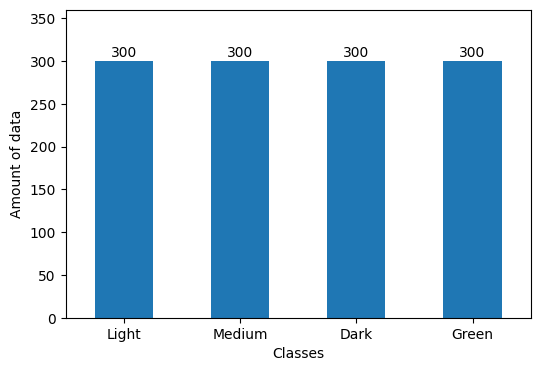

In [65]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

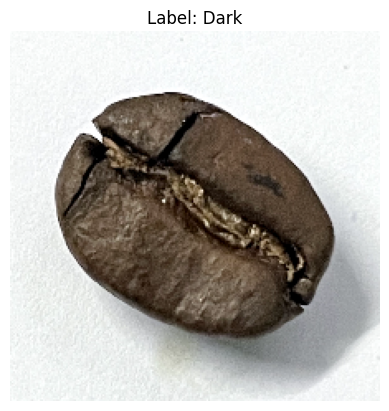

In [66]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [67]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [68]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  840
Validation Data:  180
Test Data:  180
-------------------------------------------
Total amounts of data in the dataset:  1200


In [69]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class      Count
-------  -------
Light        210
Medium       210
Green        210
Dark         210

Validation Dataset
Class      Count
-------  -------
Medium        45
Green         45
Dark          45
Light         45

Test Dataset
Class      Count
-------  -------
Medium        45
Green         45
Light         45
Dark          45


### Device Variable

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Checkpoint

In [71]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Transform

In [72]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Dark': 0, 'Green': 1, 'Light': 2,'Medium':3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [73]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Neural Network (ResNet)

In [74]:
total_class = 4
learning_rate = 0.0001

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
summary(model, input_size=(train_batch, 3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 4]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

### Training

In [75]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset,
                num_epochs=20, early_stop_patience=5, save_path_checkpoints="checkpoints"):

    # Ensure checkpoint directory exists
    os.makedirs(save_path_checkpoints, exist_ok=True)

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    print("\n========== Training Started ==========\n")

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # -------- Training Phase --------
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset), desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print(f"[Epoch {epoch+1}] Training Loss: {epoch_train_loss:.4f} | Training Accuracy: {epoch_train_acc:.4f}")

        # -------- Validation Phase --------
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = val_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f"[Epoch {epoch+1}] Validation Loss: {epoch_val_loss:.4f} | Validation Accuracy: {epoch_val_acc:.4f}")

        # -------- Early Stopping & Checkpoint --------
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = os.path.join(save_path_checkpoints, f"best_model_epoch_{best_epoch}.pt")

            torch.save({
                "epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()
            }, filepath)

            print(f"✅ Best model saved to: {filepath} with accuracy: {best_val_acc:.4f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"🛑 Early stopping at epoch {epoch+1}: No improvement for {early_stop_patience} consecutive epochs.")
            break

        epoch_time = time.time() - epoch_start_time
        print(f"⏱️ Epoch Duration: {epoch_time:.2f} seconds\n")

    print("\n========== Training Completed ==========\n")
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


# === Train the model ===
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer,
    dataloader_train_dataset, dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

# === Training Time ===
end_time = time.time()
training_time = end_time - start_time
print(f"\n🕒 Total Training Time: {training_time:.2f} seconds ({training_time / 60:.2f} minutes)")

# === Save History to Excel ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_filename = f"/kaggle/working/training_data_{timestamp}.xlsx"

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history_df = pd.DataFrame(data)
history_df.to_excel(excel_filename, index=False)

print(f"📊 Training history saved to: {excel_filename}")


========== Training Started ==========



Epoch 1/20: 100%|██████████| 27/27 [00:04<00:00,  5.43it/s, acc=0.917, loss=0.311]

[Epoch 1] Training Loss: 0.3110 | Training Accuracy: 0.9167


[Epoch 1] Validation Loss: 0.0595 | Validation Accuracy: 0.9778
✅ Best model saved to: /kaggle/working/best_model_epoch_1.pt with accuracy: 0.9778
⏱️ Epoch Duration: 6.36 seconds



Epoch 2/20: 100%|██████████| 27/27 [00:04<00:00,  5.47it/s, acc=0.988, loss=0.04]  

[Epoch 2] Training Loss: 0.0400 | Training Accuracy: 0.9881


[Epoch 2] Validation Loss: 0.0776 | Validation Accuracy: 0.9722
⏱️ Epoch Duration: 5.57 seconds



Epoch 3/20: 100%|██████████| 27/27 [00:04<00:00,  5.48it/s, acc=0.993, loss=0.0253]

[Epoch 3] Training Loss: 0.0253 | Training Accuracy: 0.9929


[Epoch 3] Validation Loss: 0.0094 | Validation Accuracy: 0.9944
✅ Best model saved to: /kaggle/working/best_model_epoch_3.pt with accuracy: 0.9944
⏱️ Epoch Duration: 6.24 seconds



Epoch 4/20: 100%|██████████| 27/27 [00:05<00:00,  5.24it/s, acc=1, loss=0.0109]

[Epoch 4] Training Loss: 0.0109 | Training Accuracy: 1.0000


[Epoch 4] Validation Loss: 0.0023 | Validation Accuracy: 1.0000
✅ Best model saved to: /kaggle/working/best_model_epoch_4.pt with accuracy: 1.0000
⏱️ Epoch Duration: 6.72 seconds



Epoch 5/20: 100%|██████████| 27/27 [00:04<00:00,  5.48it/s, acc=0.999, loss=0.00593]

[Epoch 5] Training Loss: 0.0059 | Training Accuracy: 0.9988


[Epoch 5] Validation Loss: 0.0019 | Validation Accuracy: 1.0000
⏱️ Epoch Duration: 5.55 seconds



Epoch 6/20: 100%|██████████| 27/27 [00:04<00:00,  5.49it/s, acc=1, loss=0.00289]

[Epoch 6] Training Loss: 0.0029 | Training Accuracy: 1.0000


[Epoch 6] Validation Loss: 0.0015 | Validation Accuracy: 1.0000
⏱️ Epoch Duration: 5.54 seconds



Epoch 7/20: 100%|██████████| 27/27 [00:04<00:00,  5.46it/s, acc=1, loss=0.00154]

[Epoch 7] Training Loss: 0.0015 | Training Accuracy: 1.0000


[Epoch 7] Validation Loss: 0.0016 | Validation Accuracy: 1.0000
⏱️ Epoch Duration: 5.59 seconds



Epoch 8/20: 100%|██████████| 27/27 [00:04<00:00,  5.41it/s, acc=0.998, loss=0.0173] 

[Epoch 8] Training Loss: 0.0173 | Training Accuracy: 0.9976


[Epoch 8] Validation Loss: 0.0356 | Validation Accuracy: 0.9778
⏱️ Epoch Duration: 5.61 seconds



Epoch 9/20: 100%|██████████| 27/27 [00:04<00:00,  5.47it/s, acc=0.994, loss=0.0159]

[Epoch 9] Training Loss: 0.0159 | Training Accuracy: 0.9940


[Epoch 9] Validation Loss: 0.1706 | Validation Accuracy: 0.9500
🛑 Early stopping at epoch 9: No improvement for 5 consecutive epochs.

========== Training Completed ==========


🕒 Total Training Time: 52.70 seconds (0.88 minutes)
📊 Training history saved to: /kaggle/working/training_data_20250721_090342.xlsx


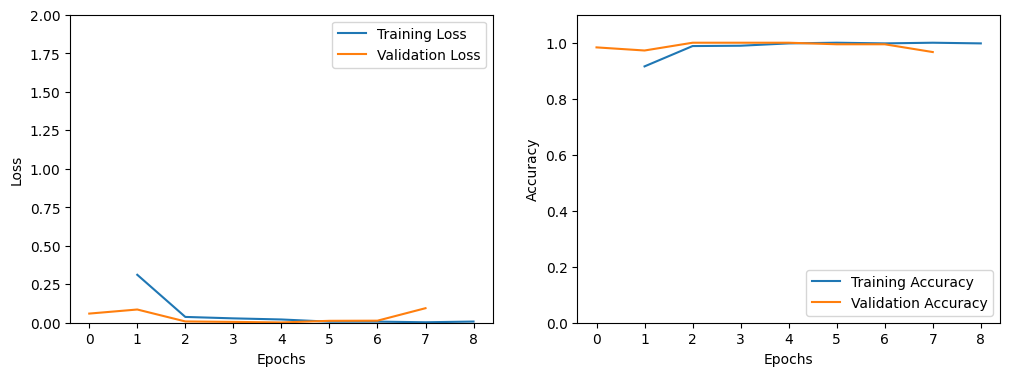

In [76]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [77]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [78]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 3) - Validation Loss: 0.008, Validation Accuracy: 1.000


In [79]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 1.000
Test Time: 0.57 seconds ---> 0.01 minutes


In [80]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        45
           2       1.00      1.00      1.00        45
           3       1.00      1.00      1.00        45

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

Class 0 Accuracy: 1.000
Class 1 Accuracy: 1.000
Class 2 Accuracy: 1.000
Class 3 Accuracy: 1.000
